In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.fft import fft, fftfreq
from scipy.io import loadmat
import h5py

In [ ]:
import os
import tqdm
import numpy as np
import librosa
import scipy.io

# Define paths
base_dir = "/content/drive/MyDrive/datasets/CTHS"
label_file = "/content/drive/MyDrive/datasets/label_matrix_CTHS.mat"

# Audio settings
sampling_rate = 2000
n_mels = 64
fixed_length = 300

# Load .mat file containing label matrix
mat = scipy.io.loadmat(label_file)
label_matrix = mat['quality_labels_remaining'].flatten()  # Flatten in case it's 2D

# Get sorted list of .wav files (must match order of labels)
wav_files = sorted([f for f in os.listdir(base_dir) if f.endswith('.wav')])

# Check if counts match
assert len(wav_files) == len(label_matrix), "Mismatch between number of audio files and labels."

# Process each audio file and extract log-Mel features
X_logmel = []
y_labels = []

for i, file_name in enumerate(tqdm.tqdm(wav_files)):
    file_path = os.path.join(base_dir, file_name)

    # Load and resample audio
    signal, sr = librosa.load(file_path, sr=None)
    signal = librosa.resample(signal, orig_sr=sr, target_sr=sampling_rate)
    signal = signal / np.max(np.abs(signal))  # Normalize

    # Compute log-Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sampling_rate, n_mels=n_mels)
    logmel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Take mean across time
    feature_vector = np.mean(logmel_spec, axis=1)  # shape: (n_mels,)

    # Pad or trim to fixed length
    if len(feature_vector) < fixed_length:
        feature_vector = np.pad(feature_vector, (0, fixed_length - len(feature_vector)), mode='constant')
    else:
        feature_vector = feature_vector[:fixed_length]

    X_logmel.append(feature_vector)
    y_labels.append(label_matrix[i])

# Convert to arrays
X_logmel = np.array(X_logmel)
y_logmel = np.array(y_labels)

print("X_logmel shape:", X_logmel.shape)
print("y_logmel shape:", y_logmel.shape)


100%|██████████| 412/412 [00:46<00:00,  8.78it/s]

X_logmel shape: (412, 300)
y_logmel shape: (412,)


In [ ]:
print(label_matrix[:20])

[3 3 2 5 5 3 2 4 5 3 3 3 2 4 4 3 3 4 3 4]


In [ ]:
import os
import tqdm
import numpy as np
import librosa
import scipy.io

def process_cths_logmel(base_dir, label_mat_file, sampling_rate=2000, feature_length=300, n_mels=64):
    X_logmel = []
    y_labels = []

    # Load label matrix from .mat file
    mat = scipy.io.loadmat(label_mat_file)

    # Find the correct label key
    keys = [key for key in mat.keys() if not key.startswith('__')]
    print("Available keys in .mat file:", keys)
    label_key = keys[0]  # Assuming the first non-metadata key is the label matrix
    label_matrix = mat[label_key].flatten()

    # Sort .wav filenames to align with label order
    wav_files = sorted([f for f in os.listdir(base_dir) if f.endswith('.wav')])

    # Sanity check
    assert len(wav_files) == len(label_matrix), "Mismatch: {} files vs {} labels".format(len(wav_files), len(label_matrix))

    def pad_or_truncate(feature, target_length):
        if len(feature) > target_length:
            return feature[:target_length]
        else:
            return np.pad(feature, (0, target_length - len(feature)), mode='constant')

    for idx, file_name in enumerate(tqdm.tqdm(wav_files)):
        file_path = os.path.join(base_dir, file_name)

        # Load and preprocess audio
        signal, sr = librosa.load(file_path, sr=None)
        signal = librosa.resample(signal, orig_sr=sr, target_sr=sampling_rate)
        signal = signal / np.max(np.abs(signal))  # Normalize

        # Compute Mel spectrogram and convert to log scale
        mel_spec = librosa.feature.melspectrogram(y=signal, sr=sampling_rate, n_mels=n_mels)
        logmel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Take mean over time to get a 1D feature
        logmel_feature = np.mean(logmel_spec, axis=1)  # shape: (n_mels,)

        # Pad or truncate
        logmel_feature = pad_or_truncate(logmel_feature, feature_length)

        X_logmel.append(logmel_feature)
        y_labels.append(label_matrix[idx])

    return np.array(X_logmel), np.array(y_labels)


In [ ]:
base_dir = "/content/drive/MyDrive/datasets/CTHS"
label_mat_file = "/content/drive/MyDrive/datasets/label_matrix_CTHS.mat"

X_logmel, y_logmel = process_cths_logmel(base_dir, label_mat_file)
print("X_logmel shape:", X_logmel.shape)
print("y_logmel shape:", y_logmel.shape)


Available keys in .mat file: ['quality_labels_remaining']


100%|██████████| 412/412 [00:17<00:00, 23.69it/s]

X_logmel shape: (412, 300)
y_logmel shape: (412,)


In [ ]:
# Get unique label values and create a mapping to integers
unique_labels = np.unique(y_logmel)
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

# Encode original labels using the mapping
y_logmel_enc = np.array([label_to_index[label] for label in y_logmel])

In [ ]:
import pandas as pd

# Assuming y_logmel_enc is already the integer-encoded label array
y_onehot_logmel = pd.get_dummies(y_logmel_enc).values
print(y_onehot_logmel.shape)

(412, 5)


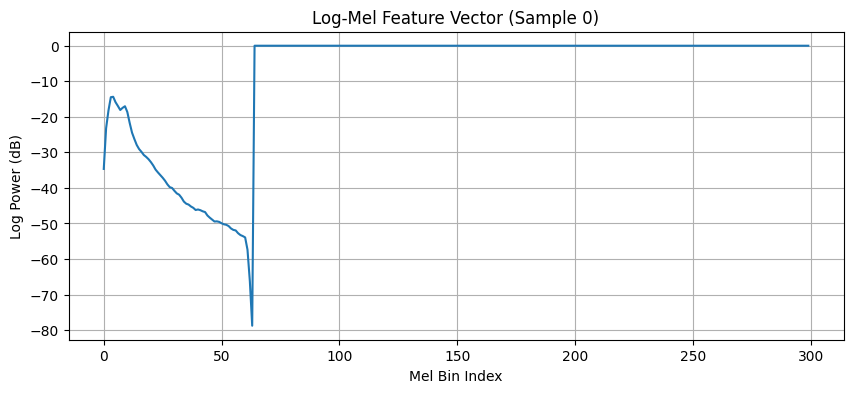

In [ ]:
import matplotlib.pyplot as plt

# Plot the first log-Mel feature vector
plt.figure(figsize=(10, 4))
plt.plot(X_logmel[0])
plt.title("Log-Mel Feature Vector (Sample 0)")
plt.xlabel("Mel Bin Index")
plt.ylabel("Log Power (dB)")
plt.grid(True)
plt.show()

In [ ]:
import os
import librosa
import numpy as np
import tqdm
import scipy.io

# Parameters
base_dir = "/content/drive/MyDrive/datasets/CTHS"
label_mat_path = "/content/drive/MyDrive/datasets/label_matrix_CTHS.mat"
sampling_rate = 2000
n_mels = 64

X_logmel_2d = []
y_logmel_2d = []
mel_specs = []
max_time_frames = 0

# Load label matrix from .mat file
mat = scipy.io.loadmat(label_mat_path)
print("MAT Keys:", mat.keys())  # Optional debug

# Replace 'label_matrix' if the key is different
label_matrix = mat['quality_labels_remaining'].flatten()

# Get sorted list of .wav files (must match order of labels)
wav_files = sorted([f for f in os.listdir(base_dir) if f.endswith('.wav')])
assert len(wav_files) == len(label_matrix), "Mismatch between number of audio files and labels"

# Step 1: Compute mel-spectrograms and track max time frames
for i, file_name in enumerate(tqdm.tqdm(wav_files, desc="Processing audio")):
    file_path = os.path.join(base_dir, file_name)

    # Load and normalize
    signal, sr = librosa.load(file_path, sr=None)
    signal = librosa.resample(signal, orig_sr=sr, target_sr=sampling_rate)
    signal = signal / np.max(np.abs(signal))

    # Compute mel-spectrogram (linear scale)
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sampling_rate, n_mels=n_mels)

    max_time_frames = max(max_time_frames, mel_spec.shape[1])

    mel_specs.append(mel_spec)
    y_logmel_2d.append(label_matrix[i])

# Step 2: Pad and convert to log scale
for mel_spec in mel_specs:
    pad_width = max_time_frames - mel_spec.shape[1]
    mel_padded = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')

    logmel_spec = librosa.power_to_db(mel_padded, ref=np.max)
    X_logmel_2d.append(logmel_spec)

# Step 3: Convert to arrays
X_logmel_2d = np.array(X_logmel_2d)  # shape: (samples, n_mels, time)
y_logmel_2d = np.array(y_logmel_2d)

# Step 4: Encode labels to integers
unique_labels = np.unique(y_logmel_2d)
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
y_logmel_enc = np.array([label_to_index[label] for label in y_logmel_2d])

# Optional: one-hot encode
# import pandas as pd
# y_logmel_onehot = pd.get_dummies(y_logmel_enc).values

# Check shapes
print("X_logmel_2d shape:", X_logmel_2d.shape)
print("y_logmel_enc shape:", y_logmel_enc.shape)


MAT Keys: dict_keys(['__header__', '__version__', '__globals__', 'quality_labels_remaining'])


Processing audio: 100%|██████████| 412/412 [00:14<00:00, 27.85it/s]


X_logmel_2d shape: (412, 64, 279)
y_logmel_enc shape: (412,)


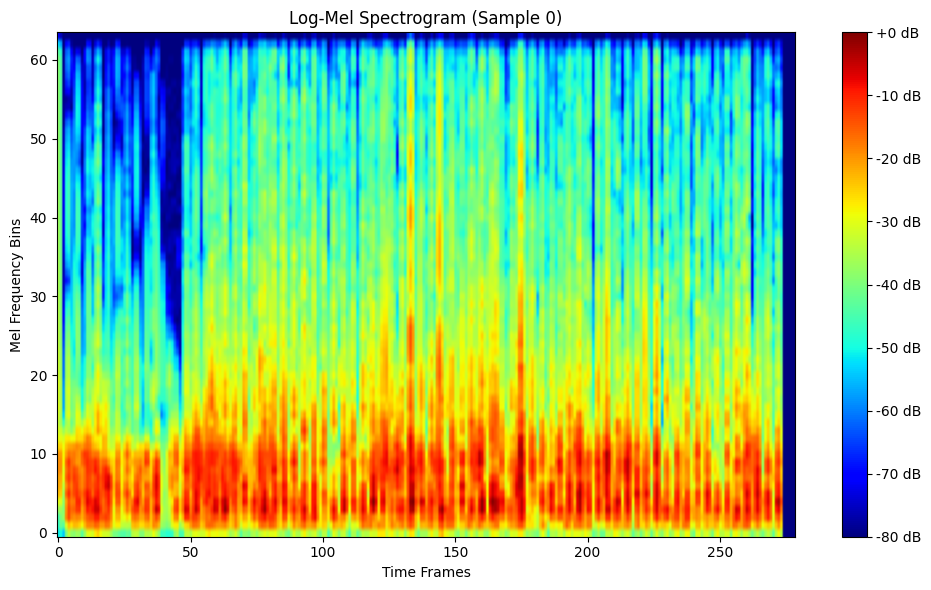

In [ ]:
import matplotlib.pyplot as plt
import numpy as np  # In case not already imported

# Visualize the first log-Mel spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(X_logmel_2d[0],           # First sample
           aspect='auto',            # Automatically scale time axis
           origin='lower',           # Low frequencies at the bottom
           cmap='jet')               # Jet colormap for better contrast

plt.colorbar(format='%+2.0f dB')     # Show color scale in decibels
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Bins")
plt.title("Log-Mel Spectrogram (Sample 0)")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GRU
from tensorflow.keras.utils import to_categorical

# === Dummy placeholder for your data ===
# X = ...  # Shape: (num_samples, time_steps, num_features)
# y = ...  # Shape: (num_samples,) or one-hot (num_samples, num_classes)

# Convert labels to one-hot if not already
if len(y.shape) == 1:
    y = to_categorical(y)

num_classes = y.shape[1]

# === Define model builder function ===
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        GRU(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# === KFold Cross-Validation ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)
val_accuracies = []
all_y_true = []
all_y_pred = []

fold = 1
for train_idx, val_idx in kf.split(X):
    print(f"\nTraining Fold {fold}...")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = build_model((X.shape[1], X.shape[2]), num_classes)
    model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=0, validation_data=(X_val, y_val))

    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    val_accuracies.append(val_acc)
    print(f"Validation Accuracy for Fold {fold}: {val_acc:.4f}")

    y_pred = model.predict(X_val, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    all_y_true.extend(y_true_classes)
    all_y_pred.extend(y_pred_classes)

    fold += 1

# === Report minimum validation accuracy ===
min_val_acc = min(val_accuracies)
print(f"\nMin Validation Accuracy: {min_val_acc:.4f}")


Training Fold 1...
Validation Accuracy for Fold 1: 0.3095

Training Fold 2...
Validation Accuracy for Fold 2: 0.3171

Training Fold 3...
Validation Accuracy for Fold 3: 0.3415

Training Fold 4...
Validation Accuracy for Fold 4: 0.3659

Training Fold 5...
Validation Accuracy for Fold 5: 0.3415

Training Fold 6...
Validation Accuracy for Fold 6: 0.2683

Training Fold 7...
Validation Accuracy for Fold 7: 0.3902

Training Fold 8...
Validation Accuracy for Fold 8: 0.3415

Training Fold 9...
Validation Accuracy for Fold 9: 0.2927

Training Fold 10...
Validation Accuracy for Fold 10: 0.3902

Min Validation Accuracy: 0.2683


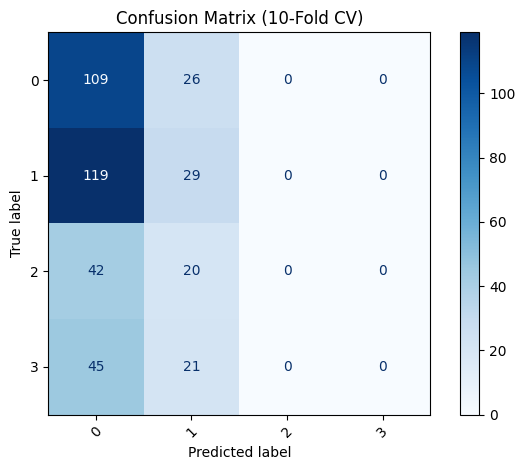

In [ ]:
# === Confusion Matrix ===
cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (10-Fold CV)")
plt.tight_layout()
plt.show()

# **CNN**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from collections import Counter # Import Counter

# Count how many samples exist for each class
class_counts = Counter(y_logmel_enc)

# Identify classes with fewer than 2 samples
classes_to_remove = [cls for cls, count in class_counts.items() if count < 2]

# Create a mask to keep only samples belonging to classes with at least 2 samples
mask = np.array([label not in classes_to_remove for label in y_logmel_enc])

# Apply the mask to filter the data
X_filtered = X_logmel_2d[mask]
y_filtered = y_logmel_enc[mask]

# Re-index y_filtered after filtering to ensure class labels are sequential starting from 0
unique_filtered_labels = np.unique(y_filtered)
old_to_new_index = {old_idx: new_idx for new_idx, old_idx in enumerate(unique_filtered_labels)}
y_reindexed = np.array([old_to_new_index[old_idx] for old_idx in y_filtered])

# Add a channel dimension to match CNN input: (samples, height, width, channels)
X = X_filtered[..., np.newaxis]  # shape: (samples, 64, time_frames, 1)

# One-hot encode labels based on the *filtered* data
num_classes = len(unique_filtered_labels) # Number of classes after filtering
y = to_categorical(y_reindexed, num_classes) # Use re-indexed filtered labels

# Split into training and testing sets using the filtered and re-indexed data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_reindexed # Stratify using the re-indexed filtered labels
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Number of classes after filtering:", num_classes)

Train shape: (328, 64, 279, 1)
Test shape: (83, 64, 279, 1)
Number of classes after filtering: 4


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 279, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 279, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 139, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 139, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 139, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 139, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 69, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 69, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 69, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 69, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 34, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 34, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 34816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,913,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,007,748 (34.36 MB)

 Trainable params: 9,007,300 (34.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.2854 - loss: 22.7081 - val_accuracy: 0.3253 - val_loss: 30.4187
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3002 - loss: 5.2945 - val_accuracy: 0.3614 - val_loss: 20.9998
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3786 - loss: 1.6378 - val_accuracy: 0.3494 - val_loss: 19.2257
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3165 - loss: 1.4444 - val_accuracy: 0.3253 - val_loss: 10.6089
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3956 - loss: 1.2966 - val_accuracy: 0.3614 - val_loss: 5.4386
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4537 - loss: 1.2866 - val_accuracy: 0.3614 - val_loss: 3.3924
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3818 - loss: 1.2389 - val_accuracy: 0.3253 - val_loss: 3.3186
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4224 - loss: 1.2594 - val_accuracy: 0.3253 - val_

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f" Final Test Accuracy: {test_accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - accuracy: 0.3012 - loss: 3.7430
 Final Test Accuracy: 31.33%


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step


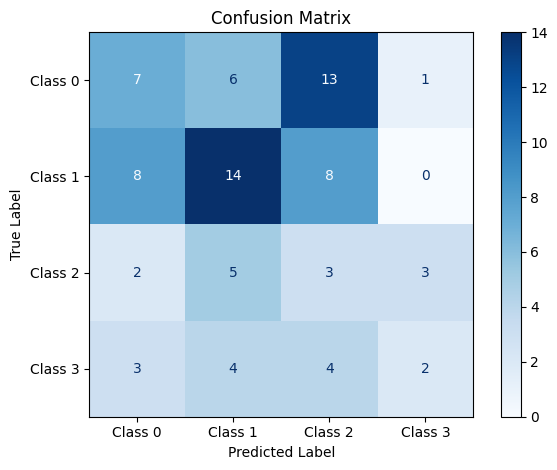

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get all classes from your dataset (e.g., 0 to 4)
all_classes = sorted(np.unique(np.concatenate([y_true, y_pred, np.arange(num_classes)])))
class_names = [f"Class {i}" for i in all_classes]  # or use real labels if available

# Force cm to include all classes
cm = confusion_matrix(y_true, y_pred, labels=all_classes)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# **GRU -> Flatten -> Dense Layer**

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GRU, Dense, Dropout, Flatten, Reshape, Permute
import matplotlib.pyplot as plt

In [ ]:
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# --- Step 1: Count samples per class ---
class_counts = Counter(y_logmel_enc)

# --- Step 2: Keep only samples from classes with at least 2 instances ---
valid_indices = [i for i, y in enumerate(y_logmel_enc) if class_counts[y] >= 2]

X_filtered = X_logmel_2d[valid_indices]
y_filtered = y_logmel_enc[valid_indices]

# --- Step 3: Reindex class labels to be consecutive integers (0 to N-1) ---
unique_classes = np.unique(y_filtered)
class_map = {old: new for new, old in enumerate(unique_classes)}
y_reindexed = np.array([class_map[y] for y in y_filtered])

# --- Step 4: Train-test split with reindexed labels ---
X_train_raw, X_test_raw, y_train_enc, y_test_enc = train_test_split(
    X_filtered, y_reindexed,
    test_size=0.2,
    random_state=42,
    stratify=y_reindexed
)

# --- Step 5: Reshape for CNN input ---
X_train = X_train_raw[..., np.newaxis]
X_test = X_test_raw[..., np.newaxis]

# --- Step 6: One-hot encode labels ---
num_classes = len(np.unique(y_reindexed))
y_train = to_categorical(y_train_enc, num_classes)
y_test = to_categorical(y_test_enc, num_classes)

# --- Debug output ---
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (328, 64, 279, 1)
y_train shape: (328, 4)
X_test shape: (83, 64, 279, 1)
y_test shape: (83, 4)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Reshape, GRU, Flatten, Dense

model = Sequential([
    # CNN Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # CNN Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Reshape to feed into GRU
    Reshape((-1, 64)),  # (batch_size, time_steps, features)

    # GRU Layer
    GRU(64, return_sequences=False),
    Dropout(0.4),

    # Fully Connected
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 279, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 279, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 139, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 139, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 139, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 139, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 69, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 69, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1104, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,996 (207.02 KB)

 Trainable params: 52,804 (206.27 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Define Callbacks (no patience used) ---
early_stop = EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5  # Reduce LR by half
)

# --- Train the Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.2914 - loss: 1.4761 - val_accuracy: 0.3253 - val_loss: 1.3610 - learning_rate: 0.0010
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.3235 - loss: 1.4265 - val_accuracy: 0.3253 - val_loss: 1.3793 - learning_rate: 0.0010


In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - accuracy: 0.3228 - loss: 1.3568
Test Accuracy: 32.53%


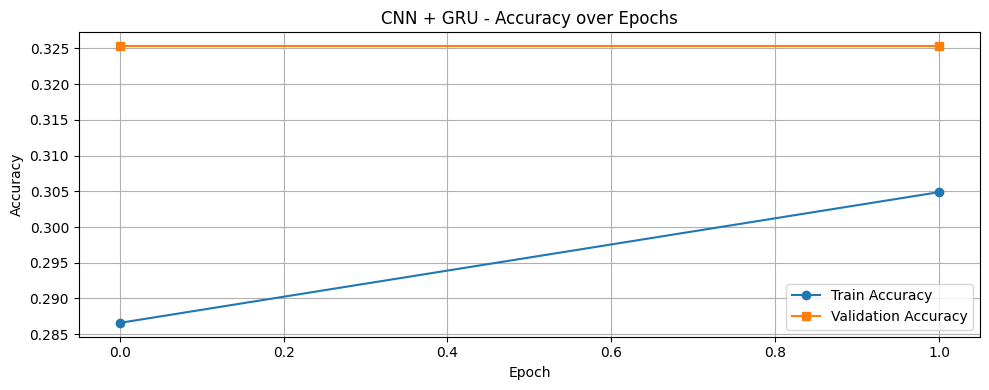

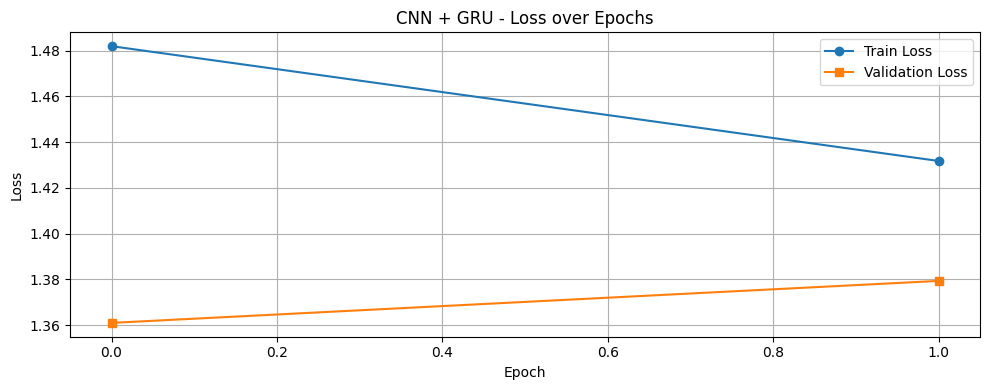

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('CNN + GRU - Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('CNN + GRU - Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


<Figure size 800x600 with 0 Axes>

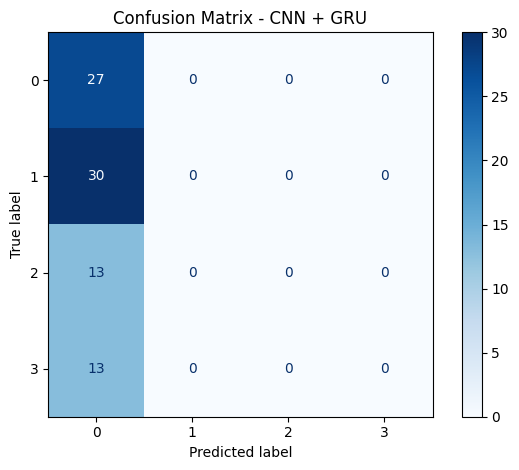

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Step 1: Predict on test set ---
y_pred_probs = model.predict(X_test)               # Shape: (num_samples, num_classes)
y_pred = np.argmax(y_pred_probs, axis=1)           # Predicted class indices
y_true = np.argmax(y_test, axis=1)                 # True class indices

# --- Step 2: Compute confusion matrix ---
cm = confusion_matrix(y_true, y_pred)

# --- Step 3: Plot confusion matrix ---
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - CNN + GRU")
plt.grid(False)
plt.tight_layout()
plt.show()


# **GRU -> Flatten -> Dense Layer**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.fft import fft, fftfreq
from scipy.io import loadmat
import h5py

In [ ]:
import os
import numpy as np
import librosa
import scipy.io
import tqdm

# Paths
base_dir = "/content/drive/MyDrive/datasets/CTHS"
label_file = "/content/drive/MyDrive/datasets/label_matrix_CTHS.mat"

# Load labels from .mat file
mat = scipy.io.loadmat(label_file)
print(mat.keys())  # Check for correct key

label_array = mat['quality_labels_remaining'].flatten()  # Replace with correct key if needed

# Load and preprocess audio files
sampling_rate = 2000
n_mels = 64
mel_specs = []
y_labels = []
max_time = 0

# Get sorted list of audio files to align with labels
wav_files = sorted([f for f in os.listdir(base_dir) if f.endswith(".wav")])
assert len(wav_files) == len(label_array)

for i, file_name in enumerate(tqdm.tqdm(wav_files)):
    file_path = os.path.join(base_dir, file_name)

    signal, sr = librosa.load(file_path, sr=None)
    signal = librosa.resample(signal, orig_sr=sr, target_sr=sampling_rate)
    signal = signal / np.max(np.abs(signal))

    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sampling_rate, n_mels=n_mels)
    max_time = max(max_time, mel_spec.shape[1])

    mel_specs.append(mel_spec)
    y_labels.append(label_array[i])


dict_keys(['__header__', '__version__', '__globals__', 'quality_labels_remaining'])


100%|██████████| 412/412 [00:15<00:00, 26.67it/s]


In [ ]:
from collections import Counter

X_logmel = []
for mel in mel_specs:
    pad_width = max_time - mel.shape[1]
    padded = np.pad(mel, ((0, 0), (0, pad_width)), mode='constant')
    logmel = librosa.power_to_db(padded, ref=np.max)
    X_logmel.append(logmel)

X_logmel = np.array(X_logmel)
y_labels = np.array(y_labels)

# Filter labels with <2 samples
counts = Counter(y_labels)
valid_idx = [i for i, y in enumerate(y_labels) if counts[y] >= 2]
X_filtered = X_logmel[valid_idx]
y_filtered = y_labels[valid_idx]

# Reindex labels
unique = np.unique(y_filtered)
label_map = {old: new for new, old in enumerate(unique)}
y_reindexed = np.array([label_map[y] for y in y_filtered])


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Flatten before GRU: reshape to (samples, time_steps, features)
X_final = np.transpose(X_filtered, (0, 2, 1))  # shape: (samples, time, mel)

# Train-test split
X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X_final, y_reindexed, test_size=0.2, stratify=y_reindexed, random_state=42
)

# One-hot encode labels
num_classes = len(np.unique(y_reindexed))
y_train = to_categorical(y_train_enc, num_classes)
y_test = to_categorical(y_test_enc, num_classes)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dropout, Dense, BatchNormalization

model = Sequential([
    Conv1D(32, 5, activation='relu', padding='same', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),

    Conv1D(64, 5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.4),

    GRU(64),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


In [ ]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 279, 32)        │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 279, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 139, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 139, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 139, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 139, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 69, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 69, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 69, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 69, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,260 (360.39 KB)

 Trainable params: 91,812 (358.64 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=[lr_scheduler])


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.3740 - loss: 1.3507 - val_accuracy: 0.1807 - val_loss: 1.5313 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.2935 - loss: 1.3493 - val_accuracy: 0.1566 - val_loss: 1.5843 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.3558 - loss: 1.3152 - val_accuracy: 0.3012 - val_loss: 1.4223 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.3296 - loss: 1.3852 - val_accuracy: 0.3494 - val_loss: 1.4430 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.3036 - loss: 1.3412 - val_accuracy: 0.3373 - val_loss: 1.4655 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.3775 - loss: 1.3154 - val_accuracy: 0.3253 - val_loss: 1.3951 - learning_rate: 0.0010
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.4121 - loss: 1.2793 - val_

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Improved Test Accuracy: {acc * 100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3150 - loss: 1.3416
Improved Test Accuracy: 32.53%


# **Flatten -> GRU -> Dense layer**

In [ ]:
import os
import numpy as np
import librosa
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, GRU, Dense


In [ ]:
import os
import numpy as np
import librosa
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, GRU, Dense, Reshape
from tensorflow.keras.preprocessing.sequence import pad_sequences

# === Step 1: Load labels from .mat file ===
mat_path = "/content/drive/MyDrive/datasets/label_matrix_CTHS.mat"
mat = scipy.io.loadmat(mat_path)

# Load label array
labels = mat['quality_labels_remaining'].squeeze()
labels = [int(l) for l in labels]  # Ensure integer labels

# === Step 2: Load and sort audio filenames ===
audio_dir = "/content/drive/MyDrive/datasets/CTHS"  # Update this
filenames = sorted([f for f in os.listdir(audio_dir) if f.endswith('.wav')])

# Ensure audio and label count match
if len(filenames) != len(labels):
    raise ValueError(f"Number of audio files ({len(filenames)}) ≠ number of labels ({len(labels)})")

# === Step 3: Filter out rare classes (occur < 2 times) ===
from collections import Counter

label_counts = Counter(labels)
valid_classes = [label for label, count in label_counts.items() if count >= 2]

filtered_filenames = []
filtered_labels = []

for fname, label in zip(filenames, labels):
    if label in valid_classes:
        filtered_filenames.append(fname)
        filtered_labels.append(label)

# === Step 4: Feature extraction - log-Mel ===
def extract_logmel(audio_path, sr=22050, n_mels=64):
    y, sr = librosa.load(audio_path, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel_spec, ref=np.max)
    return logmel.T  # (time, n_mels)

X = []
for fname in filtered_filenames:
    full_path = os.path.join(audio_dir, fname)
    logmel = extract_logmel(full_path)
    X.append(logmel)

# === Step 5: Pad sequences to same length ===
max_len = max([x.shape[0] for x in X])
X_padded = pad_sequences(X, maxlen=max_len, padding='post', dtype='float32')

# === Step 6: Encode labels ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(filtered_labels)
y_categorical = to_categorical(y_encoded)

# === Step 7: Train-test split (now safe to stratify) ===
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)

# === Step 8: Define Flatten → GRU → Dense model ===
model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),                        # Flatten time x mel
    Reshape((X_train.shape[1], X_train.shape[2])),                # Reshape for GRU
    GRU(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')           # Final layer
])

# === Step 9: Compile and train model ===
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1)

# === Step 10: Evaluate ===
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("✅ Test Accuracy:", test_acc)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.2517 - loss: 1.3891 - val_accuracy: 0.3333 - val_loss: 1.3739
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.3241 - loss: 1.3711 - val_accuracy: 0.3333 - val_loss: 1.3359
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.3408 - loss: 1.3405 - val_accuracy: 0.3333 - val_loss: 1.2910
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.3369 - loss: 1.3171 - val_accuracy: 0.3333 - val_loss: 1.2732
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.3268 - loss: 1.3167 - val_accuracy: 0.4242 - val_loss: 1.2686
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.3519 - loss: 1.3215 - val_accuracy: 0.4242 - val_loss: 1.2599
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.3470 - loss: 1.3367 - val_accuracy: 0.4242 - val_loss: 1.2741
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.3392 - loss: 1.3094 - val_accuracy: 0.3333 - val_loss:

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


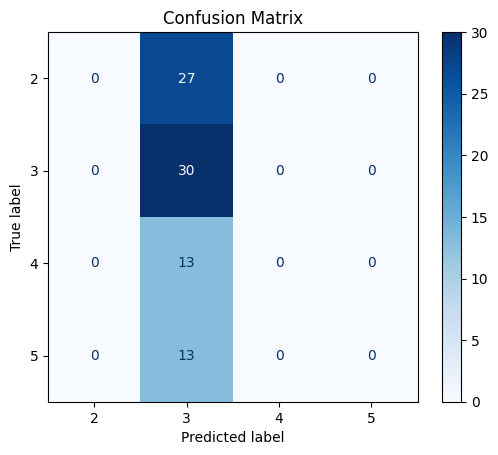

In [ ]:
# === Confusion Matrix ===
y_pred_labels = np.argmax(model.predict(X_test), axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# **CNN + Attention Model**

In [ ]:
import os
import numpy as np
import librosa
import scipy.io
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dense, Dropout,
                                     Flatten, Multiply, GlobalAveragePooling2D, Reshape)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# === Step 1: Load labels from .mat file ===
mat_path = "/content/drive/MyDrive/datasets/label_matrix_CTHS.mat"
mat = scipy.io.loadmat(mat_path)
labels = mat['quality_labels_remaining'].squeeze()
labels = [int(l) for l in labels]

# === Step 2: Load and sort audio files ===
audio_dir = "/content/drive/MyDrive/datasets/CTHS"
filenames = sorted([f for f in os.listdir(audio_dir) if f.endswith('.wav')])

if len(filenames) != len(labels):
    raise ValueError(f"Mismatch: {len(filenames)} files vs {len(labels)} labels")

# === Step 3: Filter classes with fewer than 2 samples ===
label_counts = Counter(labels)
valid_classes = [label for label, count in label_counts.items() if count >= 2]

filtered_filenames = []
filtered_labels = []

for fname, label in zip(filenames, labels):
    if label in valid_classes:
        filtered_filenames.append(fname)
        filtered_labels.append(label)

In [ ]:
# === Step 4: Extract Log-Mel features ===
def extract_logmel(path, sr=22050, n_mels=64):
    y, sr = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    return librosa.power_to_db(mel).T

X = []
for fname in filtered_filenames:
    full_path = os.path.join(audio_dir, fname)
    logmel = extract_logmel(full_path)
    X.append(logmel)

# === Step 5: Pad sequences ===
max_len = max([x.shape[0] for x in X])
X_padded = pad_sequences(X, maxlen=max_len, padding='post', dtype='float32')
X_padded = np.expand_dims(X_padded, -1)  # For Conv2D input

# === Step 6: Encode labels ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(filtered_labels)
y_categorical = to_categorical(y_encoded)

# === Step 7: Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)

In [ ]:
# === Step 8: Build CNN + Attention Model ===
input_shape = X_train.shape[1:]
inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Attention mechanism
attn = GlobalAveragePooling2D()(x)
attn = Dense(x.shape[-1], activation='softmax')(attn)
attn = Reshape((1, 1, x.shape[-1]))(attn)
x = Multiply()([x, attn])

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(y_categorical.shape[1], activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:

# === Step 9: Compile and Train ===
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# === Step 10: Evaluate ===
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(" Test Accuracy:", test_acc)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 106s 10s/step - accuracy: 0.2831 - loss: 1.9559 - val_accuracy: 0.3333 - val_loss: 1.3220
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 134s 9s/step - accuracy: 0.4544 - loss: 1.2554 - val_accuracy: 0.3939 - val_loss: 1.3982
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 146s 10s/step - accuracy: 0.5801 - loss: 1.0487 - val_accuracy: 0.4545 - val_loss: 1.3346
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 140s 10s/step - accuracy: 0.7129 - loss: 0.8672 - val_accuracy: 0.3939 - val_loss: 1.6305
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 10s/step - accuracy: 0.7633 - loss: 0.6099 - val_accuracy: 0.3636 - val_loss: 2.2337
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 98s 10s/step - accuracy: 0.8147 - loss: 0.4746 - val_accuracy: 0.3333 - val_loss: 2.3517
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 139s 9s/step - accuracy: 0.8970 - loss: 0.3466 - val_accuracy: 0.3636 - val_loss: 3.0612
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 145s 10s/step - accuracy: 0.8888 - loss: 0.2977 - val_accuracy: 0.333

3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step


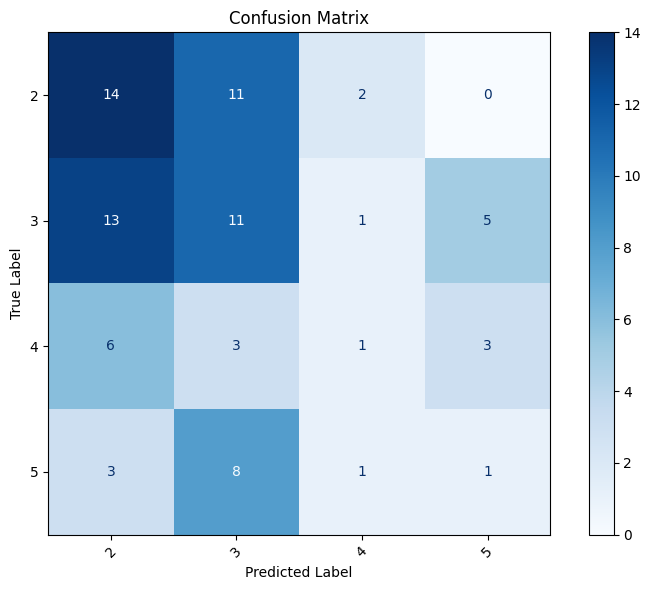

In [ ]:
# === Step 11: Confusion Matrix ===
y_pred_labels = np.argmax(model.predict(X_test), axis=1)
y_true_labels = np.argmax(y_test, axis=1)
class_names = label_encoder.inverse_transform(np.arange(len(label_encoder.classes_)))

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()